 # Import Necessary Libraries

In [1]:
!pip install focal-loss
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, 
                                     Concatenate, BatchNormalization, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras import layers
from skimage import io


# Define Functions for Image Preprocessing

In [2]:
def load_and_split_image(image_path, img_size=(192, 288)):
    full_image = io.imread(image_path)  
    if full_image.shape[1] < 1140:
        print(f"Error: Image width too small - {image_path}, Shape: {full_image.shape}")
        return None, None
    
    bscan = full_image[:, :570, :]
    mask = full_image[:, 570:, :]
    
    bscan = tf.image.resize(bscan, img_size, method=tf.image.ResizeMethod.BILINEAR).numpy()
    mask = tf.image.resize(mask, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy().astype(np.uint8)
    
    return bscan, mask

COLOR_MAP = {
    0: (255, 0, 0), 1: (255, 192, 203), 2: (0, 0, 255),
    3: (0, 255, 0), 4: (255, 255, 0), 5: (0, 0, 0)
}

# Convert RGB mask to integer label map (one channel: each pixel holds its class index)
def rgb_to_label(mask_rgb, tolerance=5):
    H, W, _ = mask_rgb.shape
    label_mask = np.zeros((H, W), dtype=np.uint8)
    for class_idx, rgb in COLOR_MAP.items():
        matches = np.all(np.abs(mask_rgb - np.array(rgb)) <= tolerance, axis=-1)
        label_mask[matches] = class_idx
    return label_mask

# Load Dataset

In [3]:
def load_dataset(txt_path, base_dir, img_size=(192, 288)):
    with open(txt_path, "r") as f:
        filenames = [line.strip() for line in f.readlines()]
    images, masks = [], []
    for filename in filenames:
        eye_id = filename.split("_")[0]
        image_path = os.path.join(base_dir, eye_id, filename)
        bscan, mask_rgb = load_and_split_image(image_path, img_size)
        if bscan is None or mask_rgb is None:
            continue
        mask_label = rgb_to_label(mask_rgb)
        images.append(bscan)
        masks.append(mask_label)
    return np.array(images), np.array(masks)

# Load your training and validation datasets
X_train, Y_train = load_dataset("/kaggle/input/amd-sd/AMD-SD/training.txt", "/kaggle/input/amd-sd/AMD-SD/images")
X_val, Y_val = load_dataset("/kaggle/input/amd-sd/AMD-SD/validation.txt", "/kaggle/input/amd-sd/AMD-SD/images")

# Normalize images; Y_train and Y_val are already integer labels of shape (batch, 192, 288)
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0

# Basic convolution block for U-Net

In [4]:

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Encoder block: conv_block then MaxPooling
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2,2))(x)
    return x, p


# Define Graph Attention Mechanism

# Decoder block: upsample, concatenate skip connection, conv_block, then Graph Attention

In [5]:
# !pip install keras
# !pip install segmentation_models

In [6]:
# !pip install keras==2.3.1
# !pip install efficientnet==1.0.0
# !pip install keras==2.9
# !pip install segmentation_models
# #!pip install segmentation-models==1.0.1

# UNET++ model to act as the teacher model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    return x

def upsample_and_align(x, target_shape, filters):
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)  # Ensure depth matches
    return x

def build_unetpp(input_shape=(192, 288, 3), num_classes=6, filters=[64, 128, 256, 512]):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (Downsampling Path)
    x00 = conv_block(inputs, filters[0])
    x10 = conv_block(layers.MaxPooling2D((2, 2))(x00), filters[1])
    x20 = conv_block(layers.MaxPooling2D((2, 2))(x10), filters[2])
    x30 = conv_block(layers.MaxPooling2D((2, 2))(x20), filters[3])
    x40 = conv_block(layers.MaxPooling2D((2, 2))(x30), filters[3])
    
    # Decoder (Nested Skip Connections)
    x01 = conv_block(layers.Concatenate()([x00, upsample_and_align(x10, x00.shape, filters[0])]), filters[0])
    x11 = conv_block(layers.Concatenate()([x10, upsample_and_align(x20, x10.shape, filters[1])]), filters[1])
    x21 = conv_block(layers.Concatenate()([x20, upsample_and_align(x30, x20.shape, filters[2])]), filters[2])
    x31 = conv_block(layers.Concatenate()([x30, upsample_and_align(x40, x30.shape, filters[3])]), filters[3])
    
    x02 = conv_block(layers.Concatenate()([x00, x01, upsample_and_align(x11, x00.shape, filters[0])]), filters[0])
    x12 = conv_block(layers.Concatenate()([x10, x11, upsample_and_align(x21, x10.shape, filters[1])]), filters[1])
    x22 = conv_block(layers.Concatenate()([x20, x21, upsample_and_align(x31, x20.shape, filters[2])]), filters[2])
    
    x03 = conv_block(layers.Concatenate()([x00, x01, x02, upsample_and_align(x12, x00.shape, filters[0])]), filters[0])
    x13 = conv_block(layers.Concatenate()([x10, x11, x12, upsample_and_align(x22, x10.shape, filters[1])]), filters[1])
    
    x04 = conv_block(layers.Concatenate()([x00, x01, x02, x03, upsample_and_align(x13, x00.shape, filters[0])]), filters[0])
    
    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x04)
    
    model = Model(inputs, outputs, name="UNetPlusPlus")
    return model


# CUSTOM METRICS (IOU, Dice, Hausdorff)

In [8]:

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_true_onehot = tf.one_hot(y_true, depth=6)
    y_pred_onehot = tf.one_hot(y_pred, depth=6)
    intersection = tf.reduce_sum(tf.cast(y_true_onehot * y_pred_onehot, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true_onehot + y_pred_onehot, tf.float32)) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_true_onehot = tf.one_hot(y_true, depth=6)
    y_pred_onehot = tf.one_hot(y_pred, depth=6)
    intersection = tf.reduce_sum(tf.cast(y_true_onehot * y_pred_onehot, tf.float32))
    dice = (2. * intersection + smooth) / (tf.reduce_sum(tf.cast(y_true_onehot, tf.float32)) + tf.reduce_sum(tf.cast(y_pred_onehot, tf.float32)) + smooth)
    return dice

from scipy.spatial.distance import directed_hausdorff
def compute_hausdorff_distance(y_true, y_pred, num_classes=6):
    hd_list = []
    for cls in range(num_classes):
        true_mask = (y_true == cls)
        pred_mask = (y_pred == cls)
        true_points = np.argwhere(true_mask)
        pred_points = np.argwhere(pred_mask)
        if true_points.size == 0 and pred_points.size == 0:
            hd = 0.0
        elif true_points.size == 0 or pred_points.size == 0:
            hd = 0.0
        else:
            d1 = directed_hausdorff(true_points, pred_points)[0]
            d2 = directed_hausdorff(pred_points, true_points)[0]
            hd = max(d1, d2)
        hd_list.append(hd)
    return np.nanmax(hd_list)

def hausdorff_distance_metric_numpy(y_true, y_pred, num_classes=6):
    y_pred = np.argmax(y_pred, axis=-1).astype(np.int32)
    y_true = y_true.astype(np.int32)
    hd_batch = []
    for i in range(y_true.shape[0]):
        hd = compute_hausdorff_distance(y_true[i], y_pred[i], num_classes=num_classes)
        hd_batch.append(hd)
    return np.array(hd_batch).mean().astype(np.float32)

def hausdorff_metric(y_true, y_pred):
    hd = tf.numpy_function(hausdorff_distance_metric_numpy, [y_true, y_pred, 6], tf.float32)
    hd.set_shape([])  # ensure the output shape is known
    return hd

In [9]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, BatchNormalization, 
    Activation, Input, Dense, Flatten, Concatenate,
    UpSampling2D  # Include this if you're using it in your U-Net style architecture
)
# Define a simpler CNN student model
def create_cnn_student_model(input_shape=(192, 288, 3), num_classes=6):
    """
    Creates a traditional CNN model for segmentation using a U-Net-like architecture
    but with standard convolutional blocks (no GAT or capsules).
    """
    # Input
    inputs = Input(input_shape)
    
    # Encoder path - traditional CNN blocks
    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Middle (bottleneck)
    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.5)(conv4)  # Add dropout for regularization
    
    # Decoder path
    # Block 3
    up3 = UpSampling2D(size=(2, 2))(conv4)
    up3 = Conv2D(128, (2, 2), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    merge3 = Concatenate()([conv3, up3])
    deconv3 = Conv2D(128, (3, 3), padding='same')(merge3)
    deconv3 = BatchNormalization()(deconv3)
    deconv3 = Activation('relu')(deconv3)
    deconv3 = Conv2D(128, (3, 3), padding='same')(deconv3)
    deconv3 = BatchNormalization()(deconv3)
    deconv3 = Activation('relu')(deconv3)
    
    # Block 2
    up2 = UpSampling2D(size=(2, 2))(deconv3)
    up2 = Conv2D(64, (2, 2), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    merge2 = Concatenate()([conv2, up2])
    deconv2 = Conv2D(64, (3, 3), padding='same')(merge2)
    deconv2 = BatchNormalization()(deconv2)
    deconv2 = Activation('relu')(deconv2)
    deconv2 = Conv2D(64, (3, 3), padding='same')(deconv2)
    deconv2 = BatchNormalization()(deconv2)
    deconv2 = Activation('relu')(deconv2)
    
    # Block 1
    up1 = UpSampling2D(size=(2, 2))(deconv2)
    up1 = Conv2D(32, (2, 2), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    merge1 = Concatenate()([conv1, up1])
    deconv1 = Conv2D(32, (3, 3), padding='same')(merge1)
    deconv1 = BatchNormalization()(deconv1)
    deconv1 = Activation('relu')(deconv1)
    deconv1 = Conv2D(32, (3, 3), padding='same')(deconv1)
    deconv1 = BatchNormalization()(deconv1)
    deconv1 = Activation('relu')(deconv1)
    
    # Output
    output = Conv2D(num_classes, (1, 1), activation='softmax')(deconv1)
    
    return Model(inputs=inputs, outputs=output, name="CNN_Student_Model")

In [10]:
from tensorflow.keras.models import load_model
import tensorflow as tf

class WeightedSparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights=[3.0, 3.0, 3.0, 4.0, 3.0, 1.0], gamma=2, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        self.gamma = gamma
        self.__name__ = 'weighted_sparse_categorical_focal_loss'
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true_int = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_int, y_pred, from_logits=False)
        
        y_pred_soft = tf.nn.softmax(y_pred)
        y_true_onehot = tf.one_hot(y_true_int, depth=tf.shape(y_pred)[-1])
        p_t = tf.reduce_sum(y_pred_soft * y_true_onehot, axis=-1)
        focal_factor = tf.pow(1 - p_t, self.gamma)
        
        weights = tf.gather(self.class_weights, y_true_int)
        loss = weights * focal_factor * ce_loss
        return tf.reduce_mean(loss)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "class_weights": self.class_weights.numpy().tolist(),
            "gamma": self.gamma
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        # Extract class_weights and gamma if they exist, otherwise use defaults
        class_weights = config.pop("class_weights", [3.0, 3.0, 3.0, 4.0, 3.0, 1.0])
        gamma = config.pop("gamma", 2)
        return cls(class_weights=class_weights, gamma=gamma, **config)

In [11]:
class EnhancedDistiller(tf.keras.Model):
    def __init__(self, student, teacher, alpha=0.5, temperature=3, feature_distillation=False, **kwargs):
        super(EnhancedDistiller, self).__init__(**kwargs)
        self.student = student
        self.teacher = teacher
        self.alpha = alpha
        self.temperature = temperature
        self.feature_distillation = feature_distillation
        
        # Initialize loss functions
        self.class_weights = [3.0, 3.0, 3.0, 4.0, 3.0, 1.0]
        self.student_loss_fn = WeightedSparseCategoricalFocalLoss(self.class_weights, gamma=2)
        self.distillation_loss_fn = tf.keras.losses.KLDivergence()
        
        # For feature distillation (optional)
        if feature_distillation:
            self.feature_loss_fn = tf.keras.losses.MeanSquaredError()
    
    def compile(self, optimizer, metrics=None, **kwargs):
        super(EnhancedDistiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
    
    def call(self, inputs, training=False):
        return self.student(inputs, training=training)
    
    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        
        with tf.GradientTape() as tape:
            # Get student predictions
            student_predictions = self.student(x, training=True)
            
            # Calculate student loss (ground truth loss)
            student_loss = self.student_loss_fn(y, student_predictions)
            
            # Knowledge distillation loss
            teacher_soft = tf.nn.softmax(teacher_predictions / self.temperature)
            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(teacher_soft, student_soft)
            
            # Combined loss
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        # Apply gradients
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        
        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({
            "loss": loss,
            "student_loss": student_loss,
            "distillation_loss": distillation_loss
        })
        return results
    
    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        loss = self.student_loss_fn(y, student_predictions)
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss})
        return results

# Compile and train the model

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

class_weights = [3.0, 3.0, 3.0, 3.0, 3.0, 1.0]
loss_instance = WeightedSparseCategoricalFocalLoss(class_weights, gamma=2)

# Build the UNet++ model
teacher_model = build_unetpp()
teacher_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_instance,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), iou_metric, dice_metric]
)

# ✅ Checkpoint Callback - Saves the best model & allows resuming training
checkpoint_callback = ModelCheckpoint(
    "teacher_model_best.keras",  # Save the best model based on validation loss
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

# ✅ Resume training if checkpoint exists
try:
    teacher_model.load_weights("teacher_model_best.h5")
    print("✅ Loaded previous checkpoint. Resuming training...")
except:
    print("⚠️ No checkpoint found. Training from scratch...")

# Train the model with checkpointing
teacher_model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_callback]
)

# Save final model
teacher_model.save("teacher_model_final.h5")
print("✅ Training complete. Model saved!")


⚠️ No checkpoint found. Training from scratch...
Epoch 1/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - dice_metric: 0.9089 - iou_metric: 0.8623 - loss: 0.4687 - sparse_categorical_accuracy: 0.9089
Epoch 1: val_loss improved from inf to 0.13817, saving model to teacher_model_best.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 273s 772ms/step - dice_metric: 0.9091 - iou_metric: 0.8625 - loss: 0.4680 - sparse_categorical_accuracy: 0.9091 - val_dice_metric: 0.9597 - val_iou_metric: 0.9231 - val_loss: 0.1382 - val_sparse_categorical_accuracy: 0.9596
Epoch 2/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - dice_metric: 0.9609 - iou_metric: 0.9249 - loss: 0.1201 - sparse_categorical_accuracy: 0.9609
Epoch 2: val_loss improved from 0.13817 to 0.10939, saving model to teacher_model_best.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 183s 623ms/step - dice_metric: 0.9609 - iou_metric: 0.9249 - loss: 0.1201 - sparse_categorical_accuracy: 0.9609 - val_dice_metric: 0.9638 - val_iou_metric: 0.9305 - val_loss: 0.1094 - val

In [13]:
# Example code to load the teacher model and create a student for distillation
def setup_distillation(teacher_model_path="/kaggle/working/teacher_model_final.h5"): 
    # Create the loss function with the same name as in the saved model
    class_weights = [3.0, 3.0, 3.0, 3.0, 3.0, 1.0]
    loss_instance = WeightedSparseCategoricalFocalLoss(class_weights, gamma=2)
    
    # Important: Create the custom objects dictionary with both the class AND function
    custom_objects = {
        "iou_metric": iou_metric, 
        "dice_metric": dice_metric,
        "weighted_sparse_categorical_focal_loss": loss_instance,
        "WeightedSparseCategoricalFocalLoss": WeightedSparseCategoricalFocalLoss
    }
    # Load the teacher model
    teacher_model = tf.keras.models.load_model(teacher_model_path, custom_objects=custom_objects)
    
    # Create a simpler CNN student model
    student_model = create_cnn_student_model()
    
    # Create the distiller
    distiller = EnhancedDistiller(
        student=student_model,
        teacher=teacher_model,
        alpha=0.6,  # Weight balance between student loss and distillation loss
        temperature=2  # Higher temperature produces softer probability distributions
    )
    
    # Compile the distiller
    distiller.compile(
        optimizer=Adam(learning_rate=1e-4),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(),
            iou_metric,
            dice_metric
        ]
    )
    
    return distiller

In [14]:
def train_distillation_model(distiller, X_train, Y_train, X_val, Y_val, epochs=15, batch_size=8):
    # Add learning rate scheduling for better convergence
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint to save the best model - UPDATED FILE EXTENSION
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_student_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model with distillation
    history = distiller.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[lr_scheduler, early_stopping, model_checkpoint]
    )
    
    # Save the final student model - UPDATED FILE EXTENSION
    distiller.student.save('best_student_model.keras')  # Changed from .h5 to .keras
    
    return history, distiller.student

In [15]:
distiller = setup_distillation()

# 2. Load or prepare your data
# For example:
# X_train, Y_train = load_training_data()
# X_val, Y_val = load_validation_data()

# 3. Call the training function with your data
history, trained_student_model = train_distillation_model(
    distiller,
    X_train, Y_train,
    X_val, Y_val,
    epochs=20,
    batch_size=8
)
distiller.student.save('best_student_model.keras') 
print("Training completed. Model saved as 'final_student_model.keras'")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - dice_metric: 0.4236 - iou_metric: 0.3400 - sparse_categorical_accuracy: 0.4236 - distillation_loss: 0.0146 - loss: 0.5492 - student_loss: 0.9056
Epoch 1: val_loss improved from inf to 0.16667, saving model to best_student_model.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


294/294 ━━━━━━━━━━━━━━━━━━━━ 141s 389ms/step - dice_metric: 0.4246 - iou_metric: 0.3409 - sparse_categorical_accuracy: 0.4246 - distillation_loss: 0.0146 - loss: 0.5486 - student_loss: 0.9046 - val_dice_metric: 0.9462 - val_iou_metric: 0.8989 - val_loss: 0.1667 - val_sparse_categorical_accuracy: 0.9462 - learning_rate: 1.0000e-04
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - dice_metric: 0.9462 - iou_metric: 0.8981 - sparse_categorical_accuracy: 0.9462 - distillation_loss: 0.0080 - loss: 0.2991 - student_loss: 0.4931
Epoch 2: val_loss improved from 0.16667 to 0.16667, saving model to best_student_model.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 90s 307ms/step - dice_metric: 0.9462 - iou_metric: 0.8981 - sparse_categorical_accuracy: 0.9462 - distillation_loss: 0.0080 - loss: 0.2988 - student_loss: 0.4927 - val_dice_metric: 0.9640 - val_iou_metric: 0.9312 - val_loss: 0.1667 - val_sparse_categorical_accuracy: 0.9640 - learning_rate: 1.0000e-04
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [16]:
print(distiller.student.summary())  # Print the summary of the student model


Model: "CNN_Student_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 192, 288, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 192, 288, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 288, 32)   │            128 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 288, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 192, 288, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 288, 32)   │            128 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 192, 288, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 96, 144, 32)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 96, 144, 64)    │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 144, 64)    │            256 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 96, 144, 64)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 96, 144, 64)    │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 144, 64)    │            256 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 96, 144, 64)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 48, 72, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 48, 72, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├──────────────────────

 Total params: 1,932,294 (7.37 MB)

 Trainable params: 1,929,030 (7.36 MB)

 Non-trainable params: 3,264 (12.75 KB)

None


Training Metrics per Epoch:
    dice_metric  iou_metric  sparse_categorical_accuracy  distillation_loss  \
0        0.7027      0.6105                       0.7020             0.0100   
1        0.9510      0.9067                       0.9510             0.0060   
2        0.9627      0.9282                       0.9628             0.0040   
3        0.9697      0.9413                       0.9697             0.0021   
4        0.9735      0.9485                       0.9735             0.0014   
5        0.9751      0.9515                       0.9751             0.0010   
6        0.9761      0.9533                       0.9760             0.0006   
7        0.9773      0.9555                       0.9773             0.0007   
8        0.9779      0.9568                       0.9779             0.0007   
9        0.9784      0.9577                       0.9784             0.0007   
10       0.9790      0.9589                       0.9790             0.0007   
11       0.9792      0.9

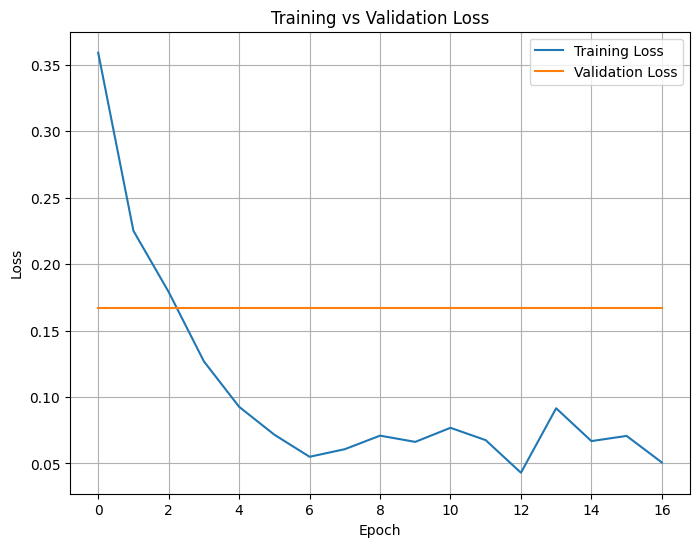

Loss plot saved to 'loss_plot.png'.


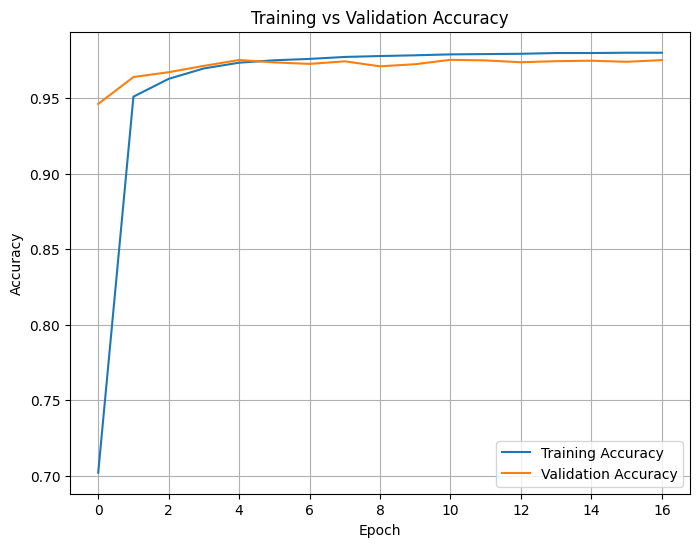

Accuracy plot saved to 'accuracy_plot.png'.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert training history dictionary to DataFrame
history_df = pd.DataFrame(history.history).round(4)

# Print the metrics table
print("Training Metrics per Epoch:")
print(history_df)

# Save the metrics table as a CSV file
history_df.to_csv("training_metrics.csv", index=False)
print("Metrics table saved to 'training_metrics.csv'.")

# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history_df['loss'], label='Training Loss')
if 'val_loss' in history_df.columns:
    plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()
print("Loss plot saved to 'loss_plot.png'.")

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_df['sparse_categorical_accuracy'], label='Training Accuracy')
if 'val_sparse_categorical_accuracy' in history_df.columns:
    plt.plot(history_df['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_plot.png")
plt.show()
print("Accuracy plot saved to 'accuracy_plot.png'.")


Unique labels in converted mask: [0 3 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction shape: (1, 192, 288, 6)
Prediction min: 2.392609e-11 max: 0.98272115
Prediction mean: 0.16666667
Unique values in predicted mask: [0 2 4 5]


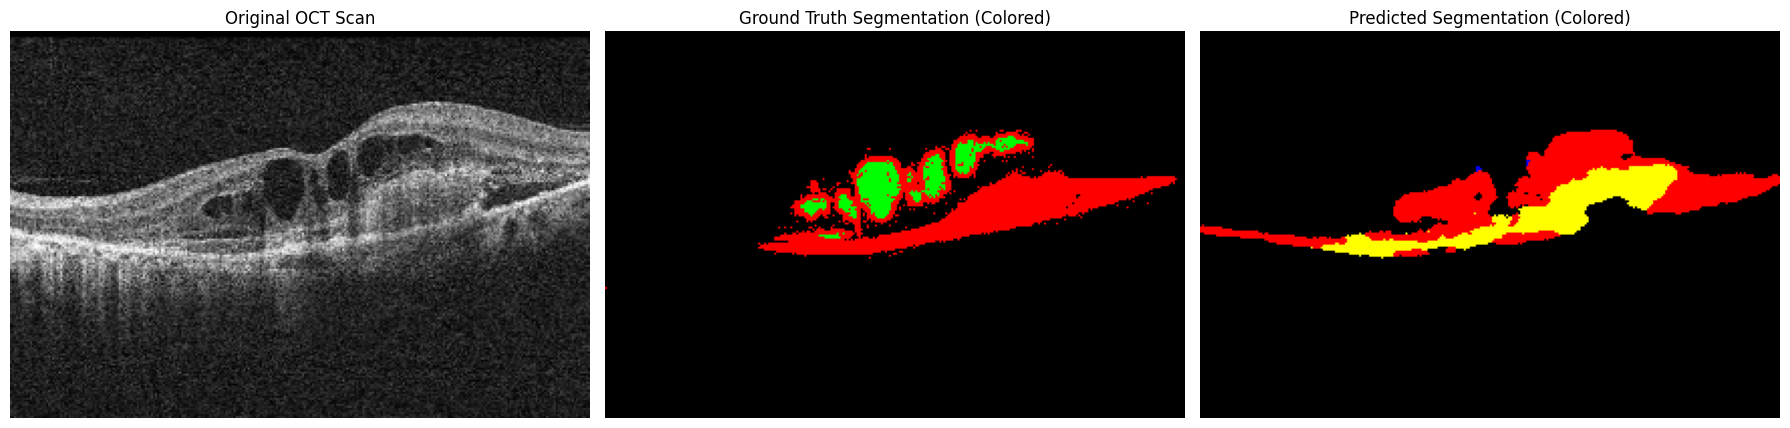

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the color map (mapping class indices to RGB tuples)
COLOR_MAP = {
    0: (255, 0, 0),      # e.g., class 0: red
    1: (255, 192, 203),  # class 1: pink
    2: (0, 0, 255),      # class 2: blue
    3: (0, 255, 0),      # class 3: green
    4: (255, 255, 0),    # class 4: yellow
    5: (0, 0, 0)         # class 5: black
}

#Function to convert an RGB mask to a label mask (integer labels)
def rgb_to_label(mask_rgb, tolerance=5):
    H, W, _ = mask_rgb.shape
    label_mask = np.zeros((H, W), dtype=np.uint8)
    for class_idx, rgb in COLOR_MAP.items():
        # Create a boolean mask where the difference between mask_rgb and rgb is within tolerance
        matches = np.all(np.abs(mask_rgb - np.array(rgb)) <= tolerance, axis=-1)
        label_mask[matches] = class_idx
    return label_mask

#Function to convert a label mask to an RGB mask using the COLOR_MAP
def label_to_rgb(label_mask):
    H, W = label_mask.shape
    rgb_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for class_idx, color in COLOR_MAP.items():
        rgb_mask[label_mask == class_idx] = color
    return rgb_mask

# Manually set the index of the validation image to inspect
manual_idx = 6 # Change this value to select a different image

# Check index range
if manual_idx < 0 or manual_idx >= len(X_val):
    print("Index out of range. Please choose an index between 0 and", len(X_val)-1)
else:
    # Retrieve the OCT scan and the corresponding ground truth mask
    # Retrieve the OCT scan and the corresponding ground truth mask
    oct_scan = X_val[manual_idx]       # Shape: (192, 288, 3)
    true_mask = Y_val[manual_idx]      # Shape: (192, 288) or (192, 288, 3)
    
    # Check if true_mask is already a label mask
    if len(true_mask.shape) == 3:  # Only convert if it's an RGB image
        converted_labels = rgb_to_label(true_mask)
    else:
        converted_labels = true_mask  # Already in label format
    
    print("Unique labels in converted mask:", np.unique(converted_labels))

    # Convert labels to RGB for visualization
    true_mask_rgb = label_to_rgb(converted_labels)
    
    # Predict the segmentation mask using the trained model (distiller)
    #oct_scan = oct_scan.astype("float32") / 255.0  # Normalize to [0, 1]
    predicted = distiller.predict(np.expand_dims(oct_scan, axis=0))
    
    print("Prediction shape:", predicted.shape)
    print("Prediction min:", np.min(predicted), "max:", np.max(predicted))
    print("Prediction mean:", np.mean(predicted))

    predicted_mask = np.argmax(predicted[0], axis=-1)  # Shape: (192, 288)
    
    # Debug Step: Check if the model is predicting valid classes
    print("Unique values in predicted mask:", np.unique(predicted_mask))
    
    # Convert predicted labels to RGB for visualization
    predicted_mask_rgb = label_to_rgb(predicted_mask)

    # Plot the original OCT scan, ground truth colored mask, and predicted colored mask
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(oct_scan)
    axes[0].set_title("Original OCT Scan")
    axes[0].axis("off")
    
    axes[1].imshow(true_mask_rgb)
    axes[1].set_title("Ground Truth Segmentation (Colored)")
    axes[1].axis("off")
    
    axes[2].imshow(predicted_mask_rgb)
    axes[2].set_title("Predicted Segmentation (Colored)")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()



In [20]:
# Load the best-performing student model
student_model = tf.keras.models.load_model("best_student_model.keras", custom_objects={
    # "GraphAttentionLayer": GraphAttentionLayer,
    # "SelfRoutingCapsuleLayer": SelfRoutingCapsuleLayer,
    "iou_metric": iou_metric,
    "dice_metric": dice_metric,
    "WeightedSparseCategoricalFocalLoss": WeightedSparseCategoricalFocalLoss
})

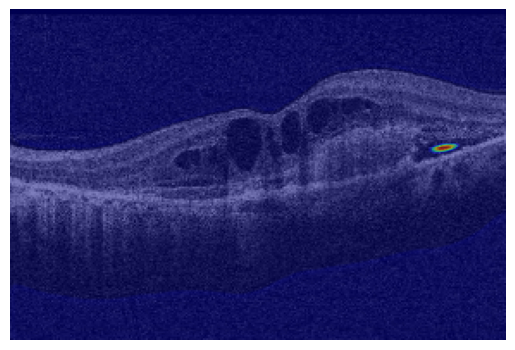

In [21]:
def grad_cam(model, img, layer_name, class_idx=None):
    """
    Generate a Grad-CAM heatmap for a segmentation model.
    :param model: The trained segmentation model.
    :param img: Input image (shape: [H, W, C]).
    :param layer_name: Name of the convolutional layer to compute Grad-CAM.
    :param class_idx: Class index to focus on (optional for segmentation).
    :return: Heatmap as a NumPy array.
    """
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        if class_idx is None:
            # Use the predicted class for each pixel
            class_idx = tf.argmax(predictions, axis=-1)  # Shape: [batch_size, height, width]
        
        # Create a one-hot encoding of the predicted class indices
        one_hot = tf.one_hot(class_idx, depth=predictions.shape[-1])  # Shape: [batch_size, height, width, num_classes]
        
        # Compute the loss as the sum of probabilities for the predicted classes
        loss = tf.reduce_sum(predictions * one_hot, axis=-1)  # Shape: [batch_size, height, width]

    grads = tape.gradient(loss, conv_outputs)[0]  # Gradients of the loss w.r.t. feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Global average pooling of gradients
    conv_outputs = conv_outputs[0]  # Feature maps

    # Compute the heatmap
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap  # Return the heatmap as a NumPy array


# Select an image from the validation set
manual_idx = 6
img = X_val[manual_idx]

# Apply Grad-CAM to the student model
layer_name = "conv2d_57"  # Replace with the name of a convolutional layer in your model
heatmap = grad_cam(student_model, img, layer_name)

# Overlay heatmap on the original image
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


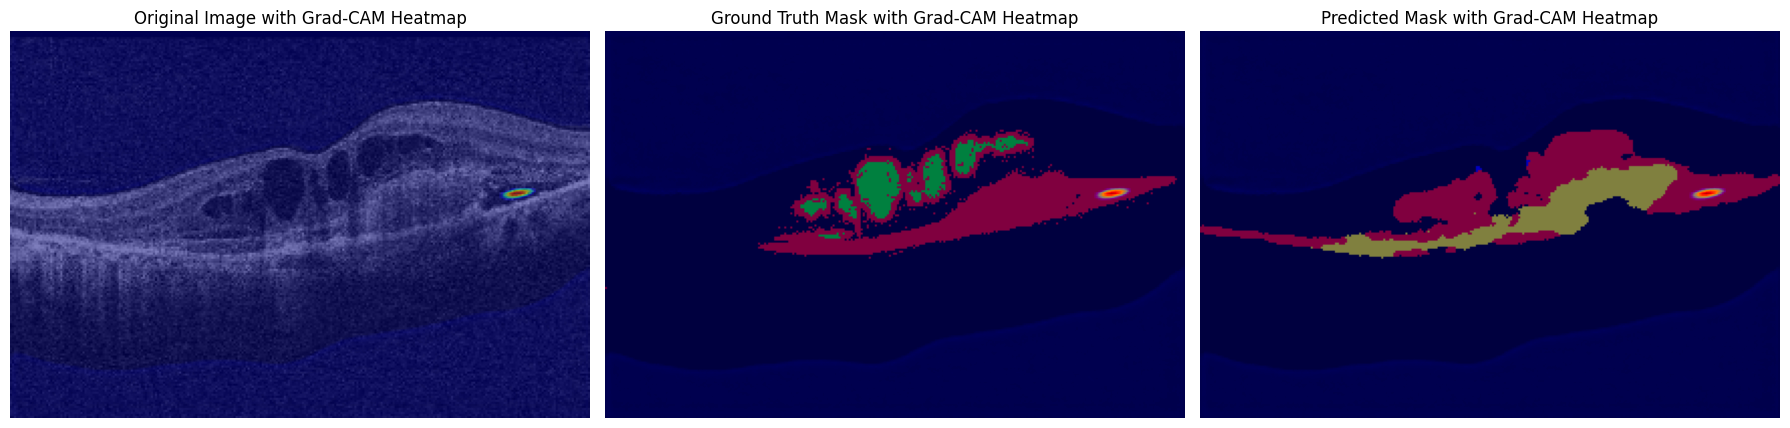

In [22]:
import matplotlib.pyplot as plt

# Select an image from the validation set
manual_idx = 6
img = X_val[manual_idx]  # Original OCT scan
true_mask = Y_val[manual_idx]  # Ground truth segmentation mask

# Convert the true mask to RGB for visualization
true_mask_rgb = label_to_rgb(true_mask)

# Apply Grad-CAM to the student model
layer_name = "conv2d_57"  # Replace with the name of a convolutional layer in your model
heatmap = grad_cam(student_model, img, layer_name)

# Resize the heatmap to match the dimensions of the input image and ground truth mask
heatmap_resized = tf.image.resize(heatmap[np.newaxis, ..., np.newaxis], 
                                  img.shape[:2],
                                  method=tf.image.ResizeMethod.BILINEAR).numpy()[0, :, :, 0]

# Predict the segmentation mask using the trained model (distiller)
predicted = distiller.predict(np.expand_dims(img, axis=0))
predicted_mask = np.argmax(predicted[0], axis=-1)  # Shape: (192, 288)
predicted_mask_rgb = label_to_rgb(predicted_mask)  # Convert predicted mask to RGB

# Create a figure with three subplots
plt.figure(figsize=(18, 6))

# Panel 1: Heatmap overlaid on the original image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.title("Original Image with Grad-CAM Heatmap")
plt.axis("off")

# Panel 2: Heatmap overlaid on the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask_rgb)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.title("Ground Truth Mask with Grad-CAM Heatmap")
plt.axis("off")

# Panel 3: Heatmap overlaid on the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_rgb)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.title("Predicted Mask with Grad-CAM Heatmap")
plt.axis("off")

# Save the figure to the /kaggle/working directory
plt.tight_layout()
plt.savefig("/kaggle/working/gradcam1_visualization.png")  # Save as PNG
plt.show()

In [ ]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# def integrated_gradients(model, img, baseline=None, m_steps=20, class_idx=None):
#     """
#     Compute Integrated Gradients for a segmentation model.
#     :param model: The trained segmentation model.
#     :param img: Input image (shape: [H, W, C]).
#     :param baseline: Baseline image (default: black image as a tf.Tensor).
#     :param m_steps: Number of interpolation steps.
#     :param class_idx: Class index to focus on (optional).
#     :return: Attribution map as a NumPy array.
#     """
#     img = tf.convert_to_tensor(img, dtype=tf.float32)  # Convert input to tf.Tensor
#     img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
#     if baseline is None:
#         baseline = tf.zeros_like(img)  # Create a tf.Tensor baseline
    
#     # Generate interpolated inputs between baseline and image
#     interpolated_inputs = [
#         baseline + (step / m_steps) * (img - baseline)
#         for step in tf.linspace(0.0, 1.0, m_steps + 1)
#     ]
#     interpolated_inputs = tf.concat(interpolated_inputs, axis=0)  # Shape: (m_steps+1, H, W, C)
    
#     # Compute gradients
#     with tf.GradientTape() as tape:
#         tape.watch(interpolated_inputs)
#         predictions = model(interpolated_inputs)  # Shape: (m_steps+1, H, W, num_classes)
        
#         if class_idx is None:
#             class_idx = tf.argmax(predictions, axis=-1)  # Predicted class per pixel
        
#         # Create one-hot encoding for the selected class
#         one_hot = tf.one_hot(class_idx, depth=predictions.shape[-1])
#         loss = tf.reduce_sum(predictions * one_hot, axis=-1)  # Pixel-wise loss
    
#     grads = tape.gradient(loss, interpolated_inputs)  # Shape: (m_steps+1, H, W, C)
#     avg_grads = tf.reduce_mean(grads, axis=0)  # Average gradients across steps
    
#     # Compute attributions
#     attributions = (img - baseline) * avg_grads
#     attributions = tf.reduce_sum(tf.abs(attributions), axis=-1)  # Sum over channels
#     attributions = attributions / tf.reduce_max(attributions)  # Normalize
    
#     return attributions.numpy()[0]  # Remove batch dimension

# # Example usage
# manual_idx = 6
# img = X_val[manual_idx].astype(np.float32)  # Ensure input is float32
# true_mask = Y_val[manual_idx]
# predicted_mask = np.argmax(student_model.predict(np.expand_dims(img, axis=0))[0], axis=-1)

# # Compute Integrated Gradients

# attributions = (img - baseline) * avg_grads

# attributions = np.sum(np.abs(attributions), axis=-1) # Absolute values for visualization`

# attributions = attributions / np.max(attributions) # Normalize

# return attributions[0] # Remove batch dimension

# # Visualize side-by-side
# plt.figure(figsize=(18, 6))

# # Original image with attributions
# plt.subplot(1, 3, 1)
# plt.imshow(img)
# plt.imshow(attributions_resized, cmap="jet", alpha=0.5)
# plt.title("Integrated Gradients on Original Image")
# plt.axis("off")

# # Ground truth mask with attributions
# plt.subplot(1, 3, 2)
# plt.imshow(label_to_rgb(true_mask))
# plt.imshow(attributions_resized, cmap="jet", alpha=0.5)
# plt.title("Integrated Gradients on Ground Truth")
# plt.axis("off")

# # Predicted mask with attributions
# plt.subplot(1, 3, 3)
# plt.imshow(label_to_rgb(predicted_mask))
# plt.imshow(attributions_resized, cmap="jet", alpha=0.5)
# plt.title("Integrated Gradients on Predicted Mask")
# plt.axis("off")

# plt.tight_layout()
# plt.savefig("/kaggle/working/integrated_gradients.png")
# plt.show()